In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

tensor([1.0000e+00, 5.6234e-01, 3.1623e-01, 1.7783e-01, 1.0000e-01, 5.6234e-02,
        3.1623e-02, 1.7783e-02, 1.0000e-02, 5.6234e-03, 3.1623e-03, 1.7783e-03,
        1.0000e-03, 5.6234e-04, 3.1623e-04, 1.7783e-04])


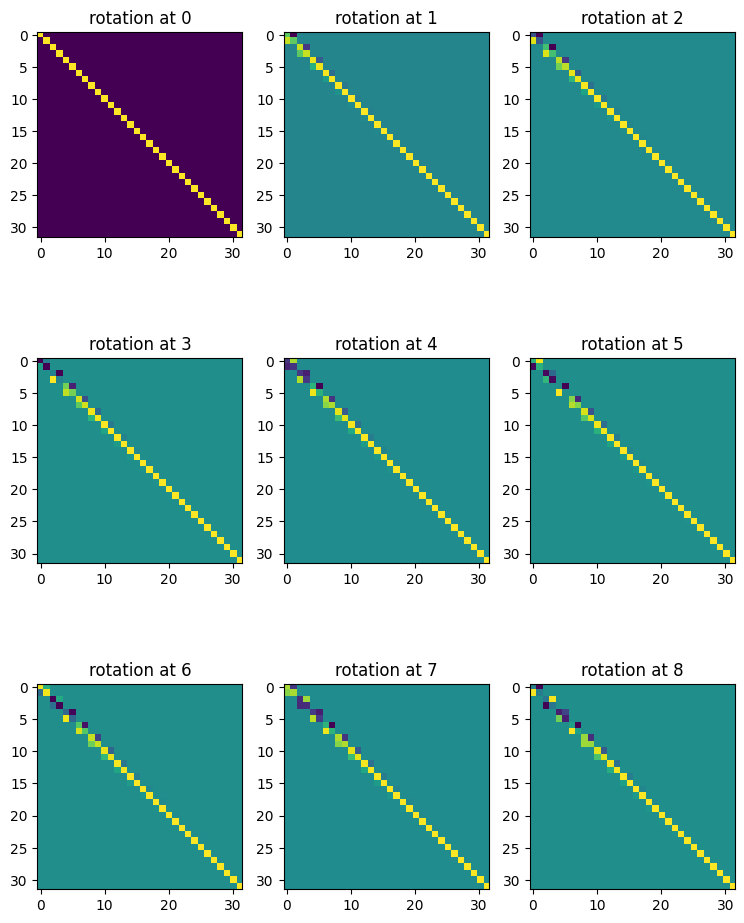

In [14]:
####### ===========Rotary Embeddings==============

def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    
    # we precompute frequencies
    theta = 10000.0
    # apply freq in pair: create a range of the embedding size with step of 2 (half of embedding size)
    # and divide by embedding_dim, to create interval between (0, 1]
    # raises theta to these powers, creating exponentially increasing values.
    # (1.0 / ...) turns this into exponentially decreasing frequencies.
    freqs = 1.0 / (theta ** (torch.arange(0, embedding_dim, 2).float() / embedding_dim))

    print(freqs)
    
    for position in range(context_window):
        for i in range(embedding_dim // 2):
            m_theta = position * freqs[i] # freq determien the speed/rate of rotation

            # The sine and cosine of m_theta are  used to create 2x2 rotation matrices for each pair of dimensions.
            R[position, 2*i, 2*i] = torch.cos(m_theta)
            R[position, 2*i, 2*i+1] = -torch.sin(m_theta)
            R[position, 2*i+1, 2*i] = torch.sin(m_theta)
            R[position, 2*i+1, 2*i+1] = torch.cos(m_theta)
    
    return R


 
K = 3
config = {
    'batch_size': 10,
    'd_model': 32,
    'n_heads': 8,
    'context_window': K**2,
}
batch = torch.randn(1, config['context_window'], config['d_model'])
R = get_rotary_matrix(config['context_window'], config['d_model'])
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f'rotation at {i * K + j}')

# *Credit: bkitano*


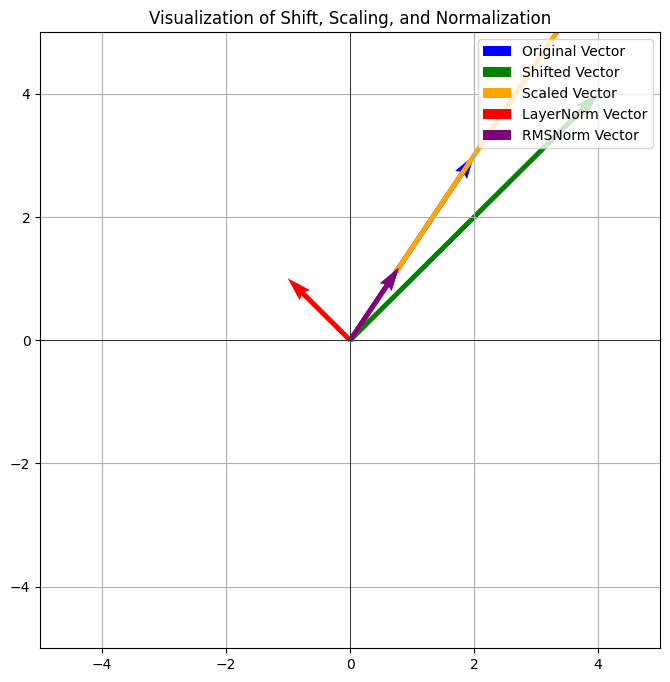

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def layer_norm(v):
    mean = np.mean(v)
    std = np.std(v)
    centered = v - mean  
    return centered / std if std != 0 else centered

def rms_norm(v):
    rms = np.sqrt(np.mean(v**2)) 
    return v / rms if rms != 0 else v


def plot_vectors(vectors, colors, labels, title):
    plt.figure(figsize=(8, 8))
    origin = np.array([[0, 0], [0, 0]])  

    for vector, color, label in zip(vectors, colors, labels):
        plt.quiver(*origin, vector[0], vector[1], color=color, scale=1, scale_units='xy', angles='xy', label=label)
    
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.show()

v = np.array([2, 3])

shifted_v = v + np.array([2, 1])  

scaled_v = v * 2  # Scale vector 

layernorm_v = layer_norm(v)

rmsnorm_v = rms_norm(v)

vectors = [v, shifted_v, scaled_v, layernorm_v, rmsnorm_v]
colors = ['blue', 'green', 'orange', 'red', 'purple']
labels = ['Original Vector', 'Shifted Vector', 'Scaled Vector', 'LayerNorm Vector', 'RMSNorm Vector']

plot_vectors(vectors, colors, labels, "Visualization of Shift, Scaling, and Normalization")


Predicting token: 'mat'

Layer 1 Attention:

    # For position 5 ('mat'):
    Q = Linear('mat')
    K = Linear([sat, on, the, mat])
    V = Linear([sat, on, the, mat])

    # Attention scores (Q·K^T):
    scores = Q @ K.transpose(-2, -1) / sqrt(d_k)  # Only attend to window tokens

    # Apply causal mask to prevent attending to future tokens
    mask = torch.triu(torch.ones(tgt_len, src_len), 1).bool()
    scores.masked_fill_(mask, float('-inf'))

    # Final attention
    attention = softmax(scores) @ V
    


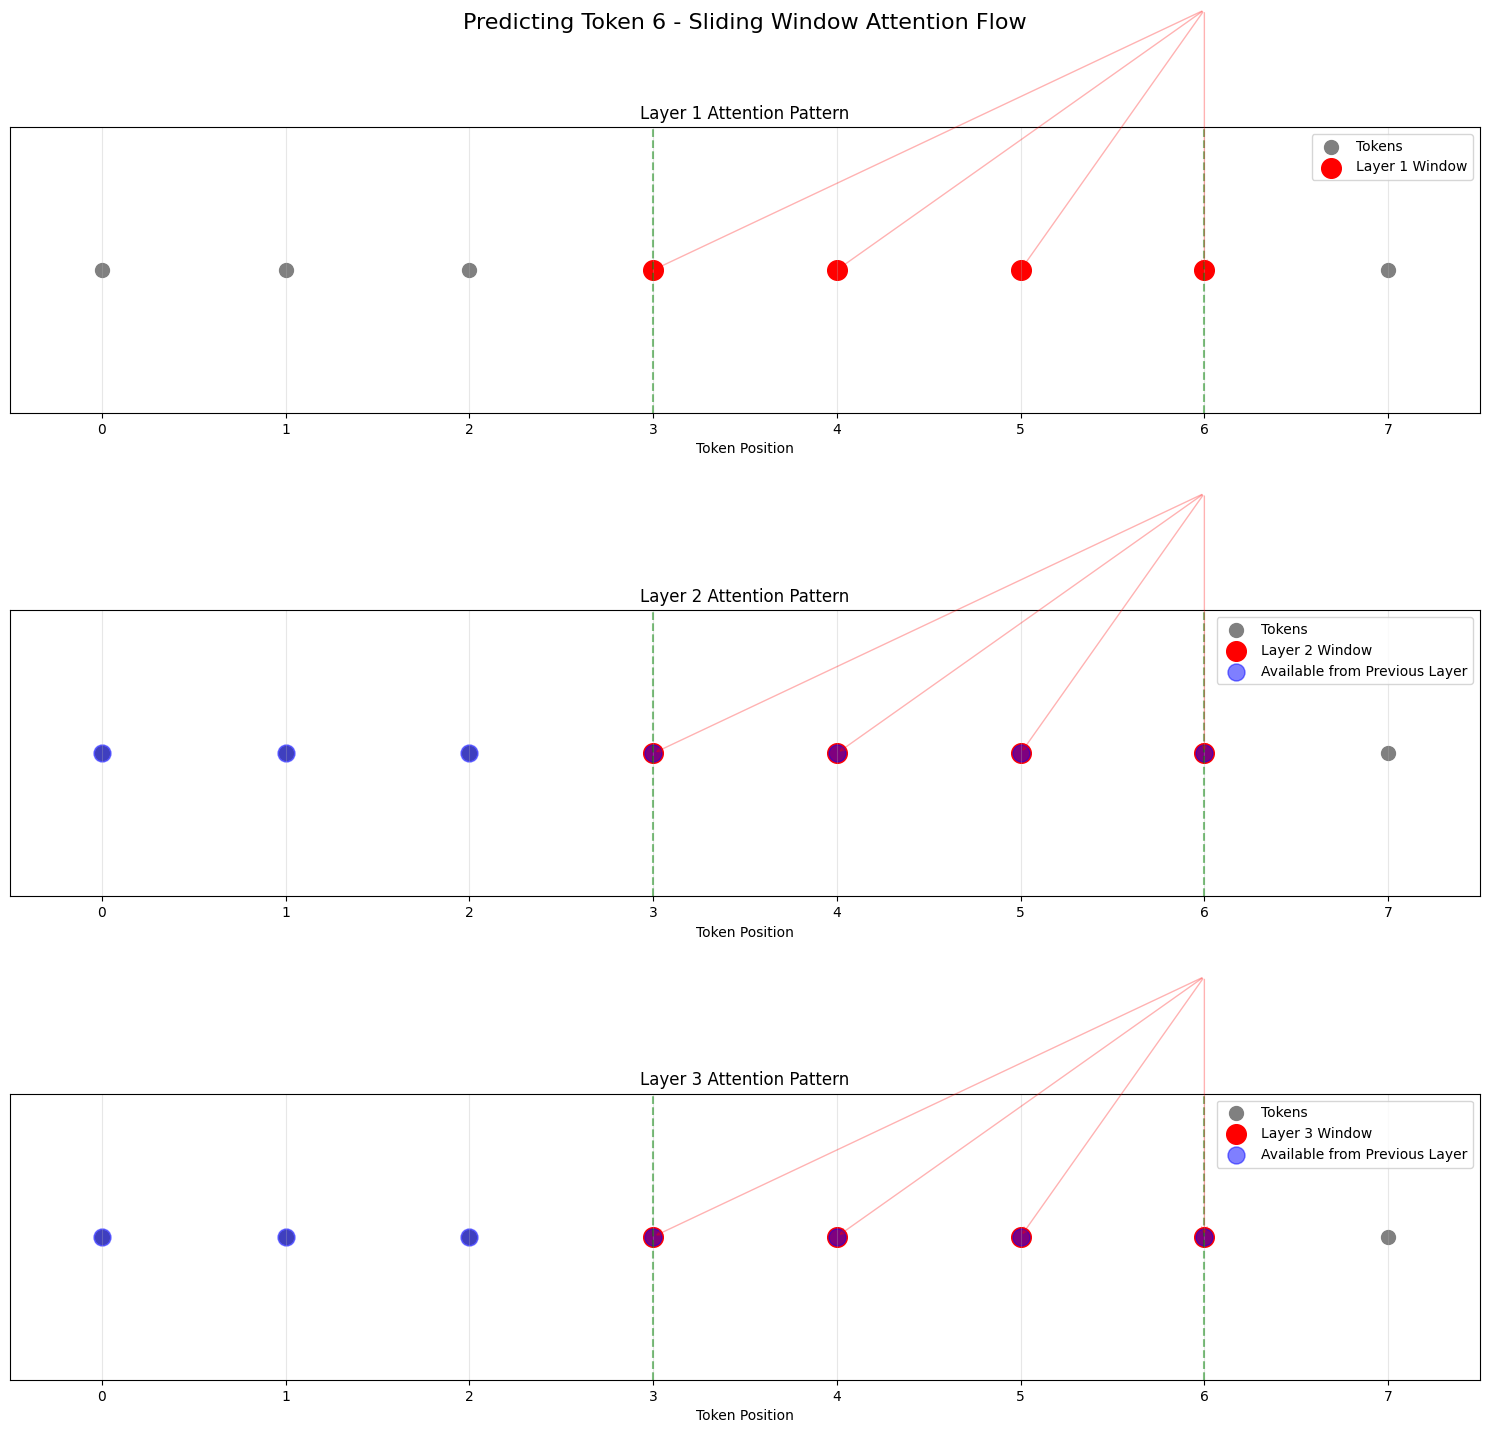

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_gpt_sliding_window(seq_length=8, window_size=4, num_layers=3):
    """
    Visualize how sliding window attention works in GPT-style autoregressive model
    for a specific target position
    """
    target_pos = 6  
    fig, axes = plt.subplots(num_layers, 1, figsize=(15, 5*num_layers))
    fig.suptitle(f'Predicting Token {target_pos} - Sliding Window Attention Flow', fontsize=16, y=0.95)


    colors = {'current_attention': 'red',
              'previous_layer': 'blue',
              'window_boundary': 'green'}


    available_info = np.zeros((num_layers, seq_length))

    for layer in range(num_layers):
        ax = axes[layer]

       
        token_positions = np.arange(seq_length)
        ax.scatter(token_positions, np.zeros_like(token_positions),
                  c='gray', s=100, label='Tokens')

       
        window_start = max(0, target_pos - window_size + 1)
        window_end = target_pos + 1  


        window_tokens = np.arange(window_start, window_end)
        ax.scatter(window_tokens, np.zeros_like(window_tokens),
                  c=colors['current_attention'], s=200,
                  label=f'Layer {layer+1} Window')

        if layer > 0:
            prev_info = np.where(available_info[layer-1, :target_pos+1] > 0)[0]
            ax.scatter(prev_info, np.zeros_like(prev_info),
                      c=colors['previous_layer'], s=150,
                      alpha=0.5, label='Available from Previous Layer')

      
        available_info[layer, :window_end] = 1

       
        ax.axvline(x=window_start, color=colors['window_boundary'],
                  linestyle='--', alpha=0.5)
        ax.axvline(x=window_end-1, color=colors['window_boundary'],
                  linestyle='--', alpha=0.5)


        ax.set_title(f'Layer {layer+1} Attention Pattern')
        ax.set_xlabel('Token Position')
        ax.set_yticks([])
        ax.set_xlim(-0.5, seq_length-0.5)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')

        for pos in window_tokens:
            ax.annotate('',
                       xy=(pos, 0),
                       xytext=(target_pos, 0.1),
                       arrowprops=dict(arrowstyle='->',
                                     color=colors['current_attention'],
                                     alpha=0.3))

    plt.tight_layout()
    return fig


fig = visualize_gpt_sliding_window()

def show_attention_calc(window_size=4):
    seq = "The cat sat on the mat"
    tokens = seq.split()
    target_pos = 5 

    print(f"Predicting token: '{tokens[target_pos]}'")
    print("\nLayer 1 Attention:")
    window_start = max(0, target_pos - window_size + 1)
    window_tokens = tokens[window_start:target_pos+1]

    Q = f"Q = Linear('{tokens[target_pos]}')"
    K = f"K = Linear([{', '.join(window_tokens)}])"
    V = f"V = Linear([{', '.join(window_tokens)}])"

    attention = f"""
    # For position {target_pos} ('{tokens[target_pos]}'):
    {Q}
    {K}
    {V}

    # Attention scores (Q·K^T):
    scores = Q @ K.transpose(-2, -1) / sqrt(d_k)  # Only attend to window tokens

    # Apply causal mask to prevent attending to future tokens
    mask = torch.triu(torch.ones(tgt_len, src_len), 1).bool()
    scores.masked_fill_(mask, float('-inf'))

    # Final attention
    attention = softmax(scores) @ V
    """

    return attention

print(show_attention_calc())